# Part II: Clinical Application


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt
from collections import Counter

In [3]:
src_path: str = "../src"
sys.path.append(src_path)

In [4]:
data_root: Path = Path("../data")

---
## 1. Exploratory Data Analysis (EDA)

Load and explore one sample of the crisdb dataset.

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.<sup>1</sup> This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.<sup>2</sup>

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex.

Find the dataset in `../data/crisdb`

In [5]:
crisdb_files = sorted(data_root.joinpath("crisdb").glob("*.npz"))
print(len(crisdb_files))

metadata = pd.read_csv(
    data_root.joinpath("crisdb").joinpath("metadata.csv"), index_col=0
)
print(metadata.shape)
metadata.head()

1537
(1543, 2)


,age,sex
subject,,
e198a,20-24,Male
e198b,20-24,Male
e028b,30-34,Male
e028a,30-34,Male
e061b,30-34,Male


What are the age and sex distributions?

Text(0.5, 0.98, 'Age and sex count distribution')

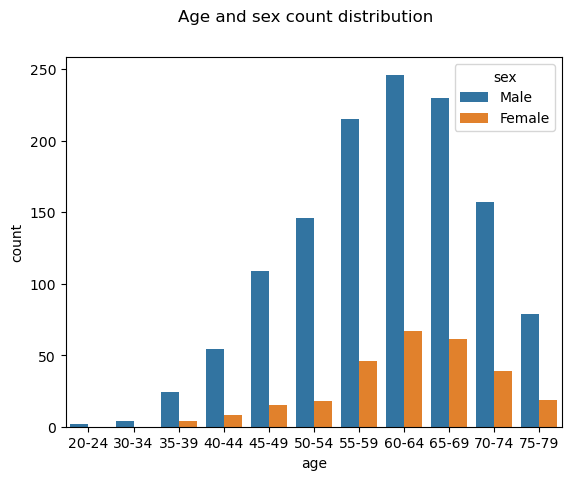

In [6]:
sns.countplot(data=metadata, x="age", hue="sex")
plt.suptitle("Age and sex count distribution", fontsize=12)

There is a clear imbalance in the data. Middle to late age population is more represented than young population, and there is significantly more male samples than females.

Do we have metadata information for all subjects?

In [7]:
assert len(set([f.stem for f in crisdb_files]).intersection(metadata.index)) == len(
    crisdb_files
)

---
## 2. Compute Resting Heart Rate

For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [8]:
resting_hr = pd.DataFrame(
    [
        {
            "subject_id": f.stem,
            "age_group": metadata.loc[f.stem, "age"],
            "sex": metadata.loc[f.stem, "sex"],
            "rhr": np.percentile(np.load(f)["hr"], 5),
        }
        for f in crisdb_files
    ]
)
resting_hr.head()

,subject_id,age_group,sex,rhr
0,e001a,60-64,Male,65.084746
1,e001b,60-64,Male,69.818182
2,e002a,65-69,Male,77.591753
3,e002b,65-69,Male,72.024615
4,e003a,55-59,Male,54.111052


---
## 3. Plot Resting Heart Rate vs. Age Group

We will use plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean.

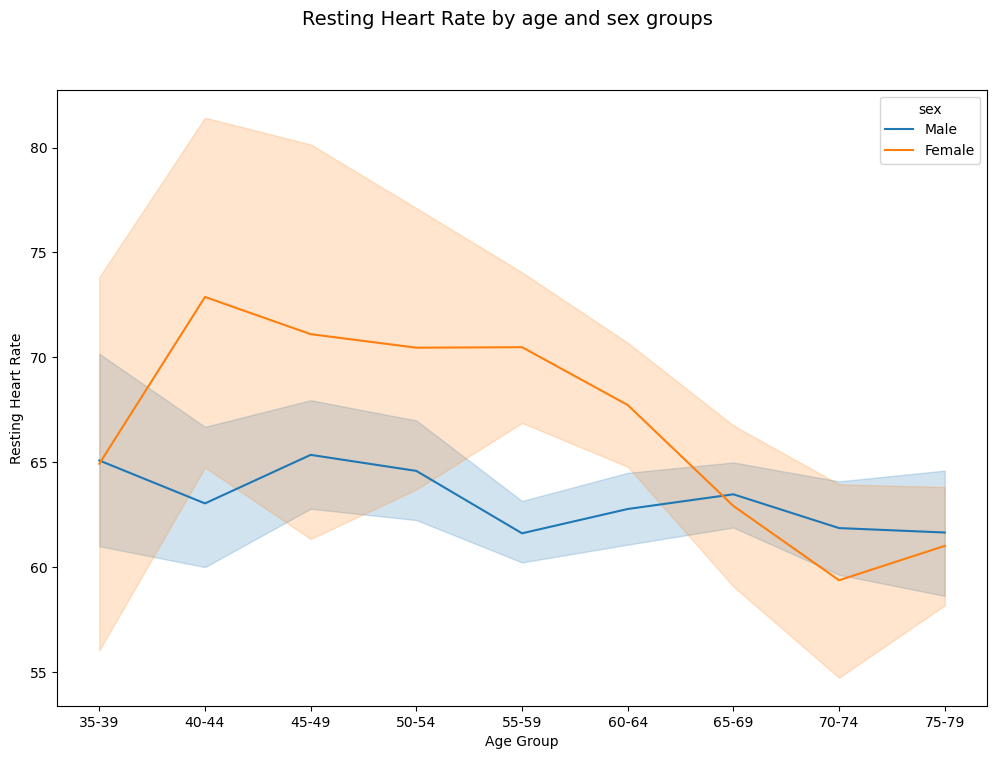

In [9]:
labels = sorted(np.unique(resting_hr.age_group))
resting_hr["xaxis"] = resting_hr.age_group.map(lambda x: labels.index(x)).astype(
    "float"
)
plt.figure(figsize=(12, 8))
sns.lineplot(x="xaxis", y="rhr", hue="sex", data=resting_hr)
plt.ylabel("Resting Heart Rate")
plt.xlabel("Age Group")
plt.suptitle("Resting Heart Rate by age and sex groups", fontsize=14)
_ = plt.xticks(np.arange(len(labels)), labels)

---
## 4. Clinical Conclusion

By observing the previous plots, we see the following observations:

1. Women's resting heart rate increases until the age group of 40-44 and then slowly decreases until the age group of 55-59. Then there is steep decrease until the age group of 70-74, with a slight recover afterwards.
2. Men's resting heart rate seem to be rather stable throughout all age groups without any sudden changes but with a slight decrease as age increases.
3. In comparison to men, women's heart rate is higher on average until the age group of 65 to 69, when it becomes slightly lower.
4. Here the size of the heart plays an important role. The smaller the heart, the less blood is pumped at each heart beat. Hearts of females are typically smaller than those of males, meaning that they need to beat at a faster rate to match the larger male heart's output.
5. We can use medical literature to understand better the underlying heart mechanistic differences between females and males. This would improve our interpretation of the results. Furthemore, we can also gather more data to include a balanced distribution between males, females and multiple races. This would allow us to get a better estimate for a more representative sample population.
6. Via simple visualization, we overall validated the trend that average resting heart rate increases up until middle age and then decreases into old age. However this was only clearly the case for females, but not so for males. Considering the low amount of young males and females and the large variance of the estimates (as depicted in the plot), we can assume that a larger cohort would be needed to better validate the trend, as well as the appropriate statistical methods such as hypothesis testing between the expected and the obtained distributions.